# Phones and Shoes

* CPM CellPhoneMeadows (250 bp)
> [*Mobile phones carry the personal microbiome of their owners*](https://peerj.com/articles/447/), James F. Meadow, Adam E. Altrichter, Jessica L. Green, **PeerJ**
* SPM SPaceMicrobes (150 bp)
> [*A microbial survey of the International Space Station (ISS)*](https://peerj.com/articles/4029/), Jenna M. Lang, David A. Coil1, Russell Y. Neches, Wendy E. Brown, Darlene Cavalier, Mark Severance, Jarrad T. Hampton-Marcell, Jack A. Gilbert, Jonathan A. Eisen, **PeerJ**
* CPJ CellPhoneJack (150 bp)
> [*Forensic analysis of the microbiome of phones and shoes*](https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-015-0082-9), Simon Lax, Jarrad T Hampton-Marcell, Sean M Gibbons, Geórgia Barguil Colares, Daniel Smith, Jonathan A Eisen and Jack A Gilbert, **BMC Microbiome**
* CPR CellPhoneRussell (150 bp)

In [2]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sb
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

def RDStoDF( rds_path ) :

    readRDS = robjects.r['readRDS']

    table = readRDS( rds_path )
    colnames = list(table.colnames)
    rownames = list(table.rownames)
    
    return pd.DataFrame( pandas2ri.ri2py(table).reshape( table.dim, order='F' ),
                         index=rownames, columns=colnames )

Populating the interactive namespace from numpy and matplotlib


In [76]:
taxtab = RDStoDF( 'data/dada2/tax_CPR_CPM_CPJ_SPM.rds' )

OTUs = pd.DataFrame( zip( taxtab.index, range(len(taxtab.index)) ), columns=['OTUseq','OTU'] ).set_index('OTUseq')

taxtab = taxtab.join(OTUs).set_index('OTU')
taxtab.head()

,Kingdom,Phylum,Class,Order,Family,Genus
OTU,,,,,,
0,Bacteria,Cyanobacteria,Chloroplast,NA,NA,NA
1,Bacteria,Tenericutes,Mollicutes,Mycoplasmatales,Mycoplasmataceae,Mycoplasma
2,Bacteria,Cyanobacteria,Chloroplast,NA,NA,NA
3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
4,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus


### Build multiple sequence alignment and tree

In [50]:
# write sequences as a FASTA file
# 
# DADA2 uses the actual sequences as sequence identifiers, which
# breaks clustalo (it truncates names to 128 characters). So, we
# have to give them temporary names.
with open( 'sequences.fasta', 'w' ) as f :
    for s,n in OTUs.iterrows() :
        f.write( '>' + 'otu_' + str(n.OTU) + '\n' + s + '\n' )

In [ ]:
!clustalo -l sequences.aln.log -o sequences.aln.fasta -i sequences.fasta

In [ ]:
!fasttreeMP -nt -gtr -gamma -log sequences.log sequences.aln.fasta > sequences.tree

In [ ]:
import pyprind

progbar = pyprind.ProgBar( len(OTUs), monitor=True )

treestring = open('sequences.tree').read()

for n,row in OTUs.iterrows() :
    progbar.update()
    otuname = 'otu_' + str(row.OTU) + ':'
    treestring = treestring.replace(otuname,row.name + ':')
    
with open( 'sequences.seqnames.tree', 'w' ) as f :
    f.write( treestring )

0% [############################  ] 100% | ETA: 00:03:45

In [77]:
seqtab = RDStoDF( 'data/dada2/seqtab_CPR_CPM_CPJ_SPM.rds' )

seqtab = seqtab.T.join(OTUs).set_index('OTU')\
               .rename_axis(None, axis=0)\
               .T.rename_axis('sample', axis=0)

seqtab.head()

,0,1,2,3,4,5,6,7,8,9,...,227619,227620,227621,227622,227623,227624,227625,227626,227627,227628
sample,,,,,,,,,,,,,,,,,,,,,
CPR_CP.AB025,901,0,427,909,1641,0,0,69,71,23,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB069,0,0,0,1335,4046,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB081,210,0,0,52,686,0,0,0,8,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB082,0,0,106,25,87,0,0,0,67,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB083,0,0,0,136,279,0,0,338,0,0,...,0,0,0,0,0,0,0,0,0,0


### Import CPR metadata

In [78]:
cpr_metadata = pd.read_csv( 'data/qiime/shoephone_mapping.tsv', sep='\t', index_col=0 )
cpr_metadata.index = [ 'CPR_' + name for name in cpr_metadata.index ]

cpr_metadata['Study'] = 'cpr'

cpr_metadata.head()

,Sample,Event,Sport,Age,Date,City,State,Run,Type,Study
CPR_CP.MC013,MC013,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr
CPR_SH.MC047,MC047,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,shoe,cpr
CPR_CP.MC042,MC042,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr
CPR_CP.ME007,ME007,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr
CPR_CP.MC019,MC019,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr


### Import and reconsile CPM metadata

In [79]:
cpm_metadata = pd.read_csv( 'data/jfmeadow/phones_map.txt', sep='\t', index_col=0 )

# NOTE : I can't figure out what Meadow's 'type' column is supposed to represent

# drop unused metadata
cpm_metadata = cpm_metadata.drop( axis=1, labels=['BarcodeSequence',
                                                  'LinkerPrimerSequence',
                                                  'barcode',
                                                  'Description',
                                                  'type'])

# reconsile metadata names
cpm_metadata.columns = [ 'Sample', 'Type', 'Hand', 'Gender', 'Wash' ]
cpm_metadata['Sample'] = [ 'JM' + name for name in cpm_metadata['Sample'] ]

# reconsile rowids from DADA2
cpm_metadata.index = [ 'CPM_' + name + '.150.1.fq' for name in cpm_metadata.index ]

# fix up the controls
cpm_controls = cpm_metadata.filter( regex='cont', axis=0 )
cpm_controls['Sample'] = [ 'JMC' + str(x) for x in range(1,6) ]
cpm_controls['Type'] = 'control'
cpm_controls['Hand'] = None
cpm_controls['Gender'] = None
cpm_controls['Wash'] = None
cpm_metadata.update( cpm_controls )

# add collection location and date/time, age and event
cpm_metadata['State'] = 'NJ'
cpm_metadata['City'] = 'Princeton'
cpm_metadata['Date'] = '5/21/2013'
cpm_metadata['Age'] = 'Adult'
cpm_metadata['Event'] = 'Workshop'
cpm_metadata['Study'] = 'cpm'

cpm_metadata.head()

/home/russell/opt/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/russell/opt/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/russell/opt/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

,Sample,Type,Hand,Gender,Wash,State,City,Date,Age,Event,Study
CPM_17.index.150.1.fq,JM17,index,r,f,n,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_17.phone.150.1.fq,JM17,phone,r,f,n,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_17.thumb.150.1.fq,JM17,thumb,r,f,n,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_18.index.150.1.fq,JM18,index,r,m,y,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_18.phone.150.1.fq,JM18,phone,r,m,y,NJ,Princeton,5/21/2013,Adult,Workshop,cpm


### Import and reconsile CPJ metadata

In [80]:
cpj_metadata = pd.read_csv( 'data/slax/mapping_file.txt', sep='\t', index_col=0 )

# reconsile metadata column names
cpj_metadata['Type'] = cpj_metadata['Surface_2']

# drop unused metadata
cpj_metadata.drop( axis=1, inplace=True, labels=['BarcodeSequence',
                                                 'LinkerPrimerSequence',
                                                 'Description',
                                                 'Surface_Person',
                                                 'Surface_Person_Time',
                                                 'Person.Env.Time',
                                                 'Position',
                                                 'Surface_2'])

# drop unused barcodes
cpj_metadata.dropna( inplace=True )

# reconsile rowids from DADA2
cpj_metadata.index = [ 'CPJ_' + str(int(name)) for name in cpj_metadata.index ]

# reconsile metadata names
cpj_metadata['PersonID'] = map( int, cpj_metadata['PersonID'] )
cpj_metadata['Sample'] = [ 'SL' + str(name) for name in cpj_metadata['PersonID'] ]
cpj_metadata.drop('PersonID', axis=1, inplace=True)
cpj_metadata['Time'] = map( int, cpj_metadata['Time'] )

# add collection location and date/time, age and event
cpj_metadata['State'] = 'IL'
cpj_metadata['City'] = 'Chicago'
cpj_metadata['Date'] = '1/23/2015'
cpj_metadata['Age'] = 'Adult'
cpj_metadata['Event'] = 'Lab'
cpj_metadata['Study'] = 'cpj'

cpj_metadata.head()

,Surface,Time,Type,Sample,State,City,Date,Age,Event,Study
CPJ_214,right_shoe_tip,1,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_228,right_shoe_tip,3,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_235,right_shoe_tip,4,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_249,right_shoe_tip,6,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_256,right_shoe_tip,7,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj


### Import and reconsile SPM metadata

In [81]:
spm_metadata = pd.read_csv( 'data/jlang/ISS.txt', sep='\t', index_col=0 )

# drop rows from other projects
spm_metadata = spm_metadata[ spm_metadata.Description == 'ISS' ]

# Drop unused metadata
spm_metadata.drop( ['Description', 'Stuff', 'Gender', 'State', 'Age' ], axis=1, inplace=True )

# The column names are messed up, so rename them
spm_metadata.columns = [ 'Module', 'Surface', 'Touches' ]

# reconsile rowids from DADA2
spm_metadata.index = [ 'SPM_' + name + '_filt.fq.gz' for name in spm_metadata.index ]

# add collection location and date/time, age and event
spm_metadata['State'] = 'Low Earth Orbit'
spm_metadata['City'] = 'International Space Station'
spm_metadata['Date'] = '4/21/2014'
spm_metadata['Age'] = 'Adult'
spm_metadata['Event'] = 'Space Microbes'
spm_metadata['Study'] = 'spm'

spm_metadata.head()

,Module,Surface,Touches,State,City,Date,Age,Event,Study
SPM_SP13_filt.fq.gz,lab,keyboard,hand,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP14_filt.fq.gz,lab,handrail,hand,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP3_filt.fq.gz,lab,mic,hand/mouth,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP7_filt.fq.gz,lab,vent,dust,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP1_filt.fq.gz,lab,mic,hand/mouth,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm


### Merge metadata

In [82]:
metadata = cpr_metadata.append( cpj_metadata ).append( cpm_metadata ).append( spm_metadata )

# Make sure missing data is consistently represented
metadata.loc[ metadata['Gender'] == 'none',    'Gender' ] = np.nan
metadata.loc[ metadata['Hand']   == 'none',    'Hand'   ] = np.nan
metadata.loc[ metadata['Sport']  == 'None',    'Sport'  ] = np.nan
metadata.loc[ metadata['Sport']  == 'Unknown', 'Sport'  ] = np.nan
metadata.loc[ metadata['Wash']   == 'none',    'Wash'   ] = np.nan

metadata.head()

,Age,City,Date,Event,Gender,Hand,Module,Run,Sample,Sport,State,Study,Surface,Time,Touches,Type,Wash
CPR_CP.MC013,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC013,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN
CPR_SH.MC047,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC047,Basketball,PA,cpr,NaN,NaN,NaN,shoe,NaN
CPR_CP.MC042,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC042,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN
CPR_CP.ME007,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,ME007,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN
CPR_CP.MC019,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC019,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN


### Drop metadata for failed samples in CPR dataset

In [128]:
failed = list( set( cpr_metadata.index ) - set( filter( lambda x : x.startswith( 'CPR_' ), seqtab.index ) ) )

metadata.drop(failed, inplace=True)

print 'dropped', len(failed), 'samples'

dropped 252 samples


In [129]:
set(seqtab.index) - set(metadata.index)

set()

In [130]:
metadata.to_csv( 'all_metadata.tsv', sep='\t' )

### Load data into phyloseq

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

library(phyloseq); packageVersion("phyloseq")
library(ggplot2); packageVersion("ggplot2")
library(dada2)
library(ape)

/home/russell/opt/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)


In [3]:
%%R

seqtree <- read.tree( "sequences.seqnames.tree" )
seqtab <- readRDS( "data/dada2/seqtab_CPR_CPM_CPJ_SPM.rds" )
taxtab <- readRDS( "data/dada2/tax_CPR_CPM_CPJ_SPM.rds" )
metadata <- read.csv( "all_metadata.tsv", sep="\t", row.names=1 )

In [4]:
%%R

ps <- phyloseq(otu_table(seqtab, taxa_are_rows=FALSE), 
               sample_data(metadata), 
               tax_table(taxtab),
               seqtree)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 227629 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 227629 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 227629 tips and 227627 internal nodes ]


In [5]:
%%R

ps0 <- subset_taxa( ps,
    # Kingdom == "Bacteria" &
    Family  != "mitochondria" &
    Class   != "Chloroplast"
  )
ps0

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 155229 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 155229 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 155229 tips and 155227 internal nodes ]


From here, we are loosely following the workflow described in

> [*Bioconductor workflow for microbiome data analysis: from raw reads to community analyses*](https://f1000research.com/articles/5-1492/v2
), Ben J. Callahan, Kris Sankaran, Julia A. Fukuyama, Paul J. McMurdie, Susan P. Holmes, **F1000**

with some diversions. Notably, we directly call [`clustal omega`](http://www.clustal.org/omega/) to
make the multiple sequence alignment and [`FastTreeMP`](http://www.microbesonline.org/fasttree/) to
build the phylogenetic tree (see above), rather than working through R as suggested in Callahan *et al.*

In [6]:
%%R

# Define prevalence of each taxa
# (in how many samples did each taxa appear at least once)
prev0 = apply(X = otu_table(ps0),
    MARGIN = ifelse(taxa_are_rows(ps0), yes = 1, no = 2),
    FUN = function(x){sum(x > 0)})

prevdf = data.frame(Prevalence = prev0,
                      TotalAbundance = taxa_sums(ps0),
                      tax_table(ps0))

keepPhyla = table(prevdf$Phylum)[(table(prevdf$Phylum) > 5)]

prevdf1 = subset(prevdf, Phylum %in% names(keepPhyla))

# Define prevalence threshold as 5% of total samples
prevalenceThreshold = 0.05 * nsamples(ps0)
prevalenceThreshold

[1] 133.65


In [7]:
%%R

# Execute prevalence filter, using `prune_taxa()` function
ps1 = prune_taxa((prev0 > prevalenceThreshold), ps0)
ps1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1928 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1928 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1928 tips and 1927 internal nodes ]


In [8]:
%%R

# Filter entries with unidentified Phylum.
ps2 = subset_taxa(ps1, Phylum %in% names(keepPhyla))
ps2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1928 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 1928 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1928 tips and 1927 internal nodes ]


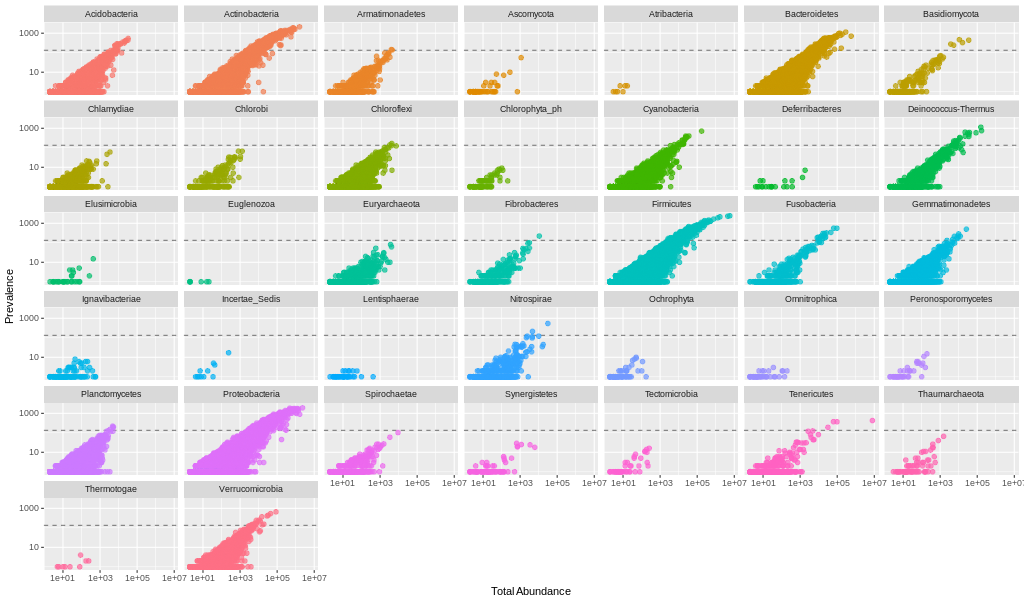

In [9]:
%%R -w 1024 -h 600 -u px

ggplot(prevdf1, aes(TotalAbundance, Prevalence, color = Phylum)) +
  geom_hline(yintercept = prevalenceThreshold, alpha = 0.5, linetype = 2) +
  geom_point(size = 2, alpha = 0.7) +
  scale_y_log10() + scale_x_log10() +
  xlab("Total Abundance") +
  facet_wrap(~Phylum) +
  theme(legend.position="none")

In [10]:
%%R

## ---- glom ----
# Taxonomic agglomeration
# How many genera are present after filtering?
taxGlomRank = "Genus"
length(get_taxa_unique(ps2, taxonomic.rank = taxGlomRank))

ps3 = tax_glom(ps2, taxrank = taxGlomRank)
# Phylogenetic agglomeration
# How many genera are present after filtering?
h1 = 0.4
ps4 = tip_glom(ps2, h = h1)
ps4

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 291 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 291 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 291 tips and 290 internal nodes ]


In [11]:
%%R

plot_abundance = function(physeq, ylabn = "",
                            Facet = "Order",
                            Color = "Phylum"){
    mphyseq = psmelt(physeq)
    mphyseq <- subset(mphyseq, Abundance > 0)
    ggplot( data = mphyseq,
            mapping = aes_string(x = "Type", y = "Abundance",
                                 color = Color, fill = Color)) +
    geom_violin(fill = NA) +
    geom_point( size = 1, alpha = 0.3,
                position = position_jitter(width = 0.3)) +
    facet_wrap(facets = Facet) + ylab(ylabn) +
    scale_y_log10()
}

# Transform to relative abundance. Save as new object.
ps3ra = transform_sample_counts(ps3, function(x){x / sum(x)})

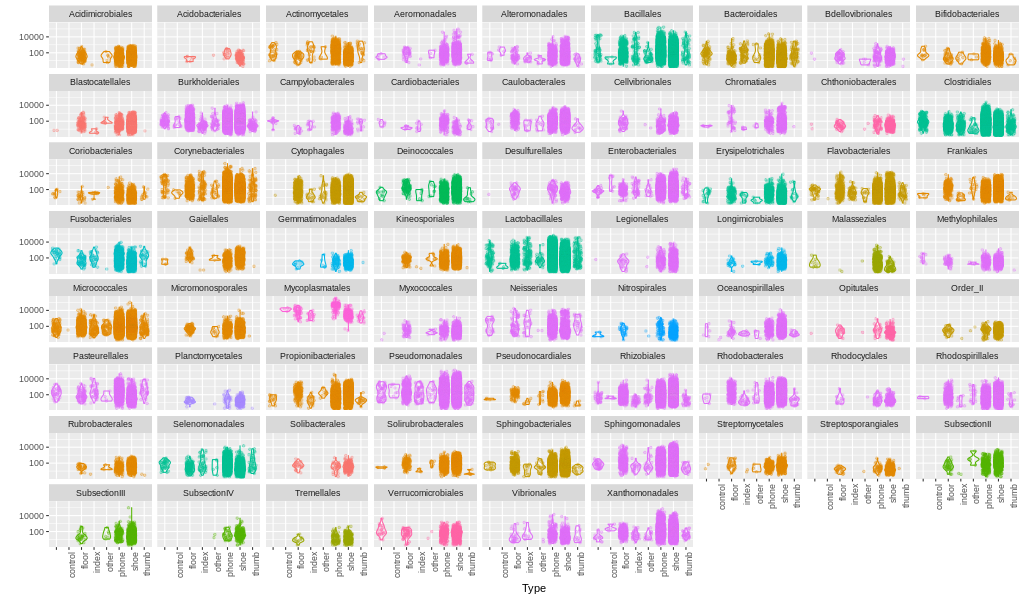

In [12]:
%%R -w 1024 -h 600 -u px

plot_abundance( ps3, "" ) +
    theme( legend.position="none",
           axis.text.x = element_text(angle = 90, hjust = 1) )

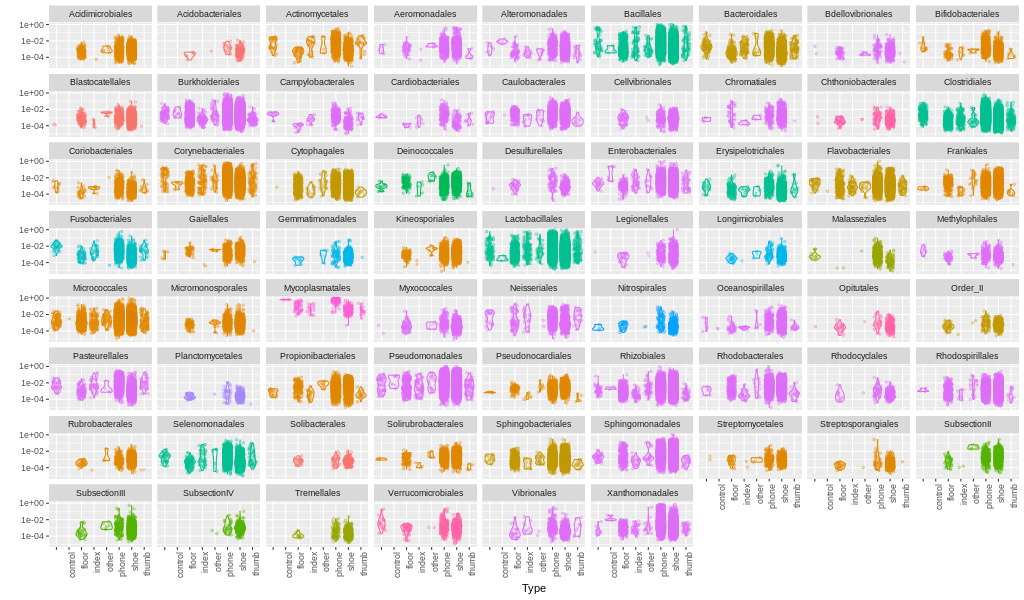

In [13]:
%%R -w 1024 -h 600 -u px

plot_abundance(ps3ra,"") +
    theme( legend.position="none",
           axis.text.x = element_text(angle = 90, hjust = 1) )

In [ ]:
%%R -w 1024 -h 600 -u px

plot_bar(ps3, x="Type", fill="Phylum") + 
    geom_bar(aes(color=Phylum, fill=Phylum), stat="identity", position="stack")

In [14]:
%%R

ps5 <- prune_samples(sample_sums(ps4)>=1, ps4)

ord.nmds.bray <- ordinate(ps5, method="NMDS", distance="bray")

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1563582 
Run 1 stress 0.17512 
Run 2 stress 0.1769127 
Run 3 stress 0.1743104 
Run 4 stress 0.1726657 
Run 5 stress 0.1796445 
Run 6 stress 0.1667253 
Run 7 stress 0.1740724 
Run 8 stress 0.1720682 
Run 9 stress 0.167702 
Run 10 stress 0.1741855 
Run 11 stress 0.1801827 
Run 12 stress 0.169789 
Run 13 stress 0.1708279 
Run 14 stress 0.1734067 
Run 15 stress 0.1786477 
Run 16 stress 0.1702192 
Run 17 stress 0.1714695 
Run 18 stress 0.169858 
Run 19 stress 0.1749683 
Run 20 stress 0.1730575 
*** No convergence -- monoMDS stopping criteria:
    14: no. of iterations >= maxit
     4: stress ratio > sratmax
     2: scale factor of the gradient < sfgrmin


In [57]:
%%R

ps5

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 291 taxa and 2652 samples ]
sample_data() Sample Data:       [ 2652 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 291 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 291 tips and 290 internal nodes ]


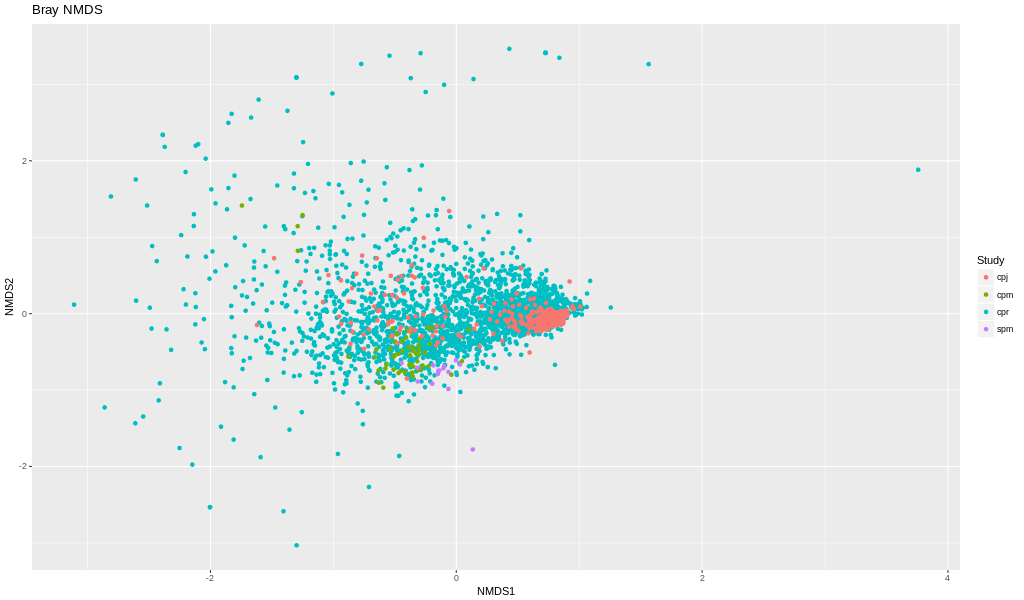

In [15]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.nmds.bray, color="Study", title="Bray NMDS")

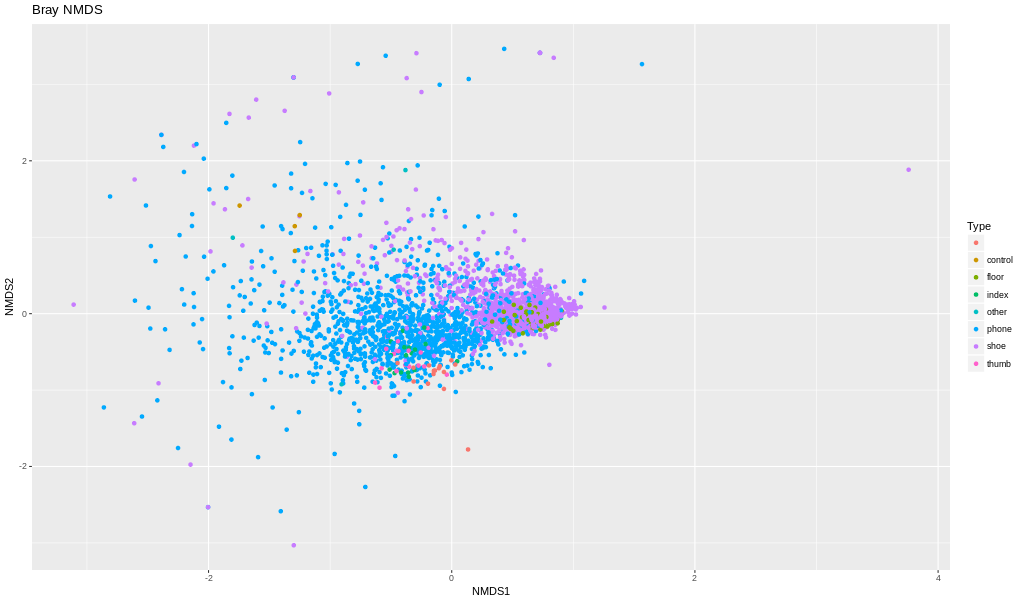

In [16]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.nmds.bray, color="Type", title="Bray NMDS")

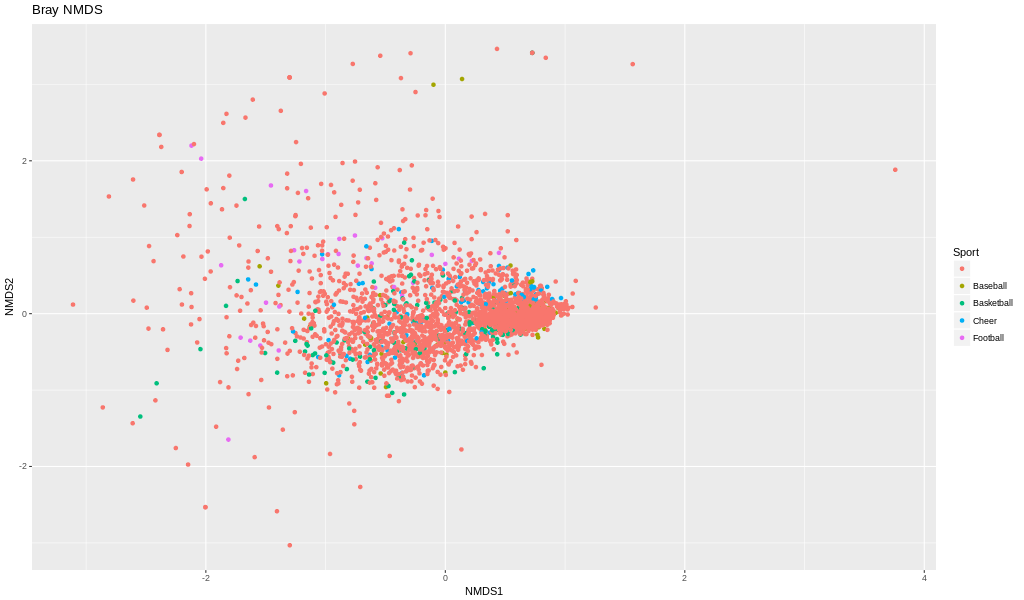

In [17]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.nmds.bray, color="Sport", title="Bray NMDS")

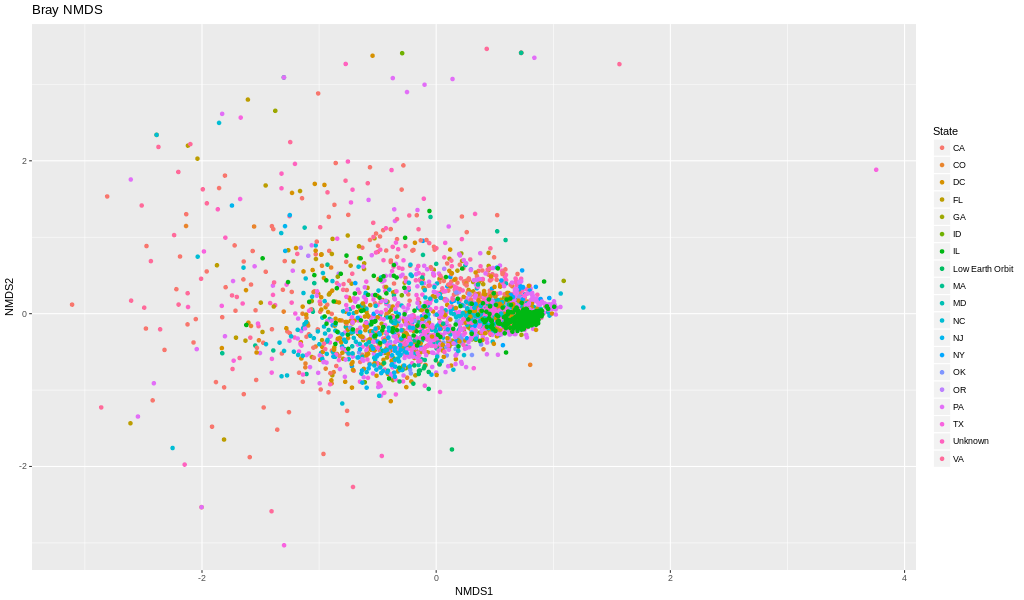

In [18]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.nmds.bray, color="State", title="Bray NMDS")

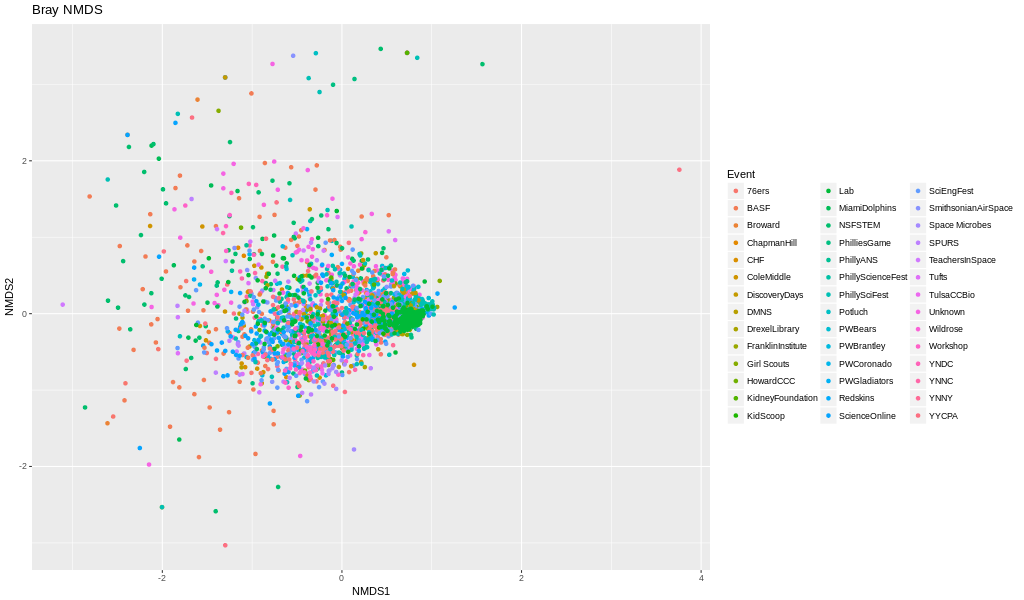

In [19]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.nmds.bray, color="Event", title="Bray NMDS")

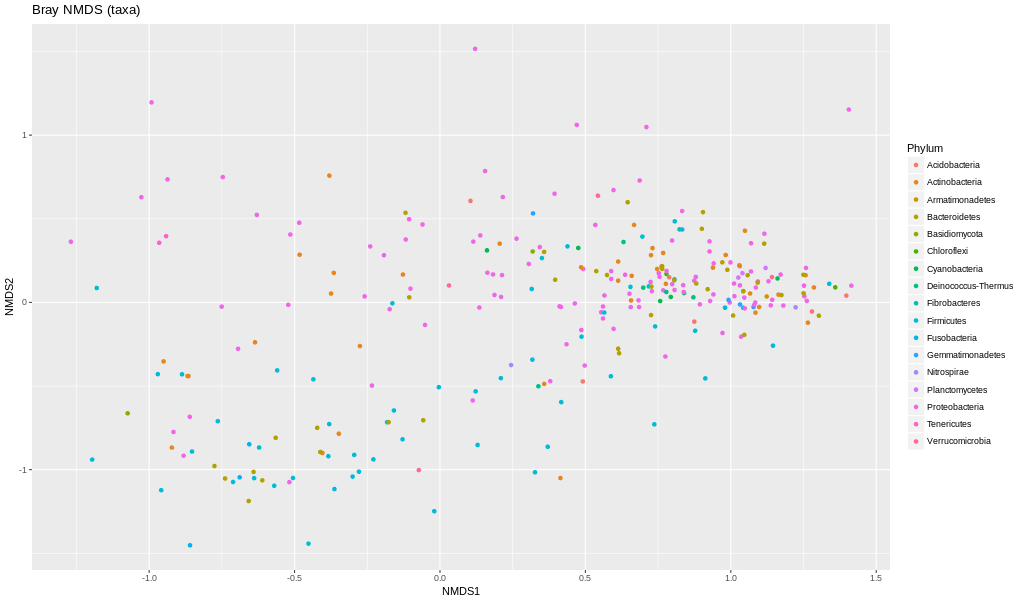

In [20]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.nmds.bray, type="taxa", color="Phylum", title="Bray NMDS (taxa)")

In [21]:
%%R

ord.pcoa.bray <- ordinate(ps5, method="PCoA", distance="bray")

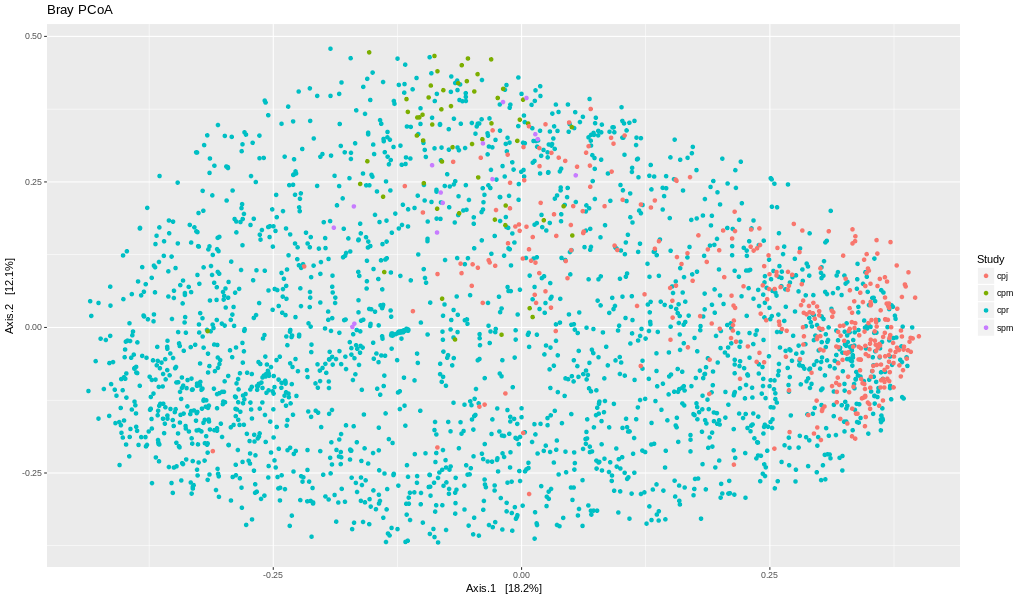

In [22]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.pcoa.bray, color="Study", title="Bray PCoA")

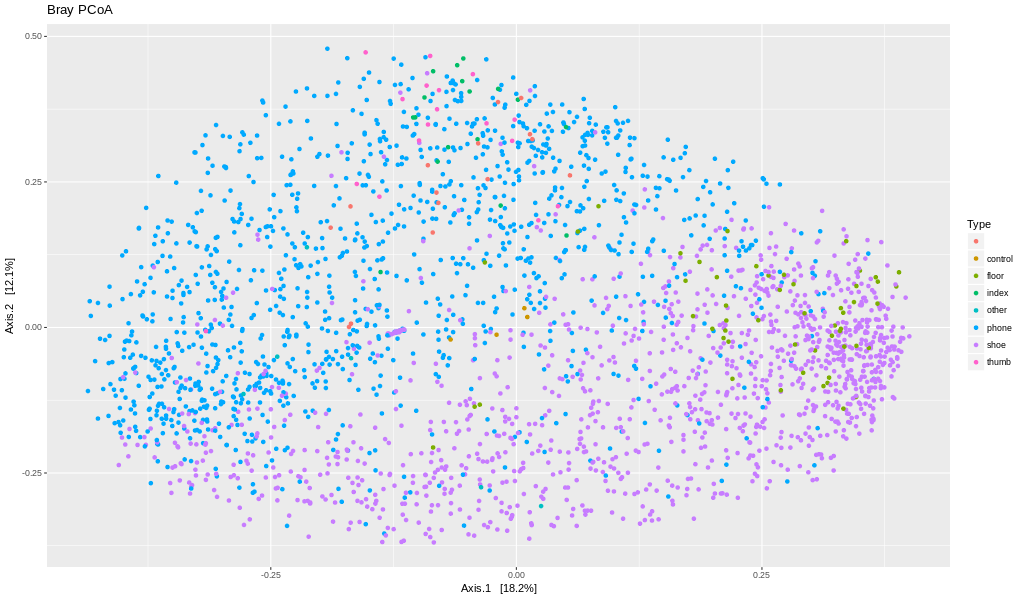

In [23]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.pcoa.bray, color="Type", title="Bray PCoA")

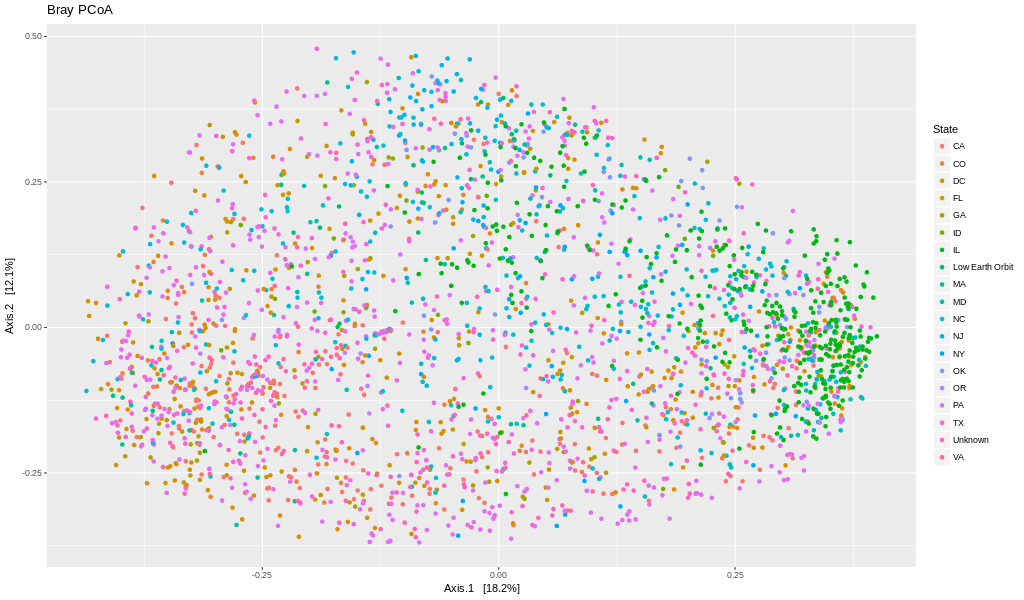

In [24]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.pcoa.bray, color="State", title="Bray PCoA")

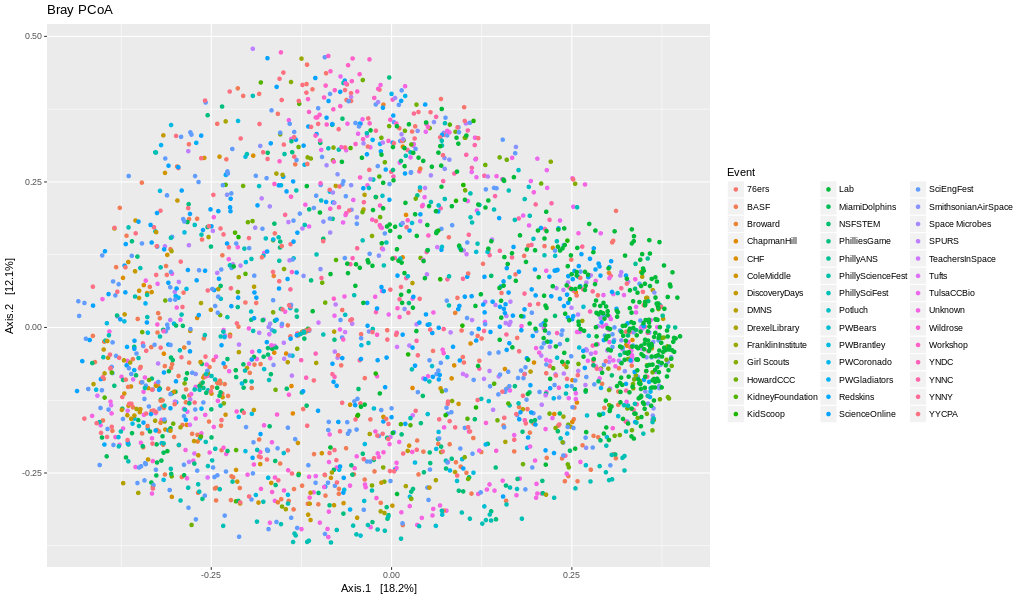

In [25]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.pcoa.bray, color="Event", title="Bray PCoA")

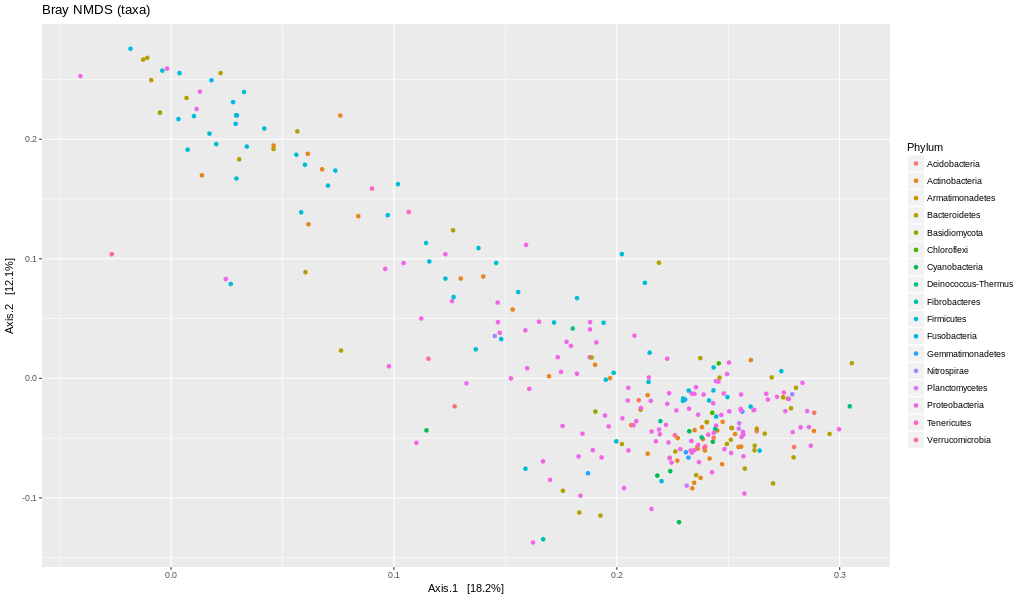

In [26]:
%%R -w 1024 -h 600 -u px

plot_ordination(ps5, ord.pcoa.bray, type="taxa", color="Phylum", title="Bray NMDS (taxa)")

In [31]:
%%R -w 1024 -h 600 -u px

top20 <- names(sort(taxa_sums(ps3ra), decreasing=TRUE))[1:20]
ps5.top20 <- transform_sample_counts(ps3ra, function(OTU) OTU/sum(OTU))
ps5.top20 <- prune_taxa(top20, ps5.top20)
plot_bar(ps5.top20, x="Type", fill="Phylum") + facet_wrap(~Type, scales="free_x")


Error in validObject(.Object) : invalid class “otu_table” object: 
 OTU abundance data must have non-zero dimensions.


In [171]:
%%R

write.csv(ord.pcoa.bray$vectors, row.names=sample_names(ps5), col.names=0, file="ord.pcoa.bray_phylum.csv")
write.csv(otu_table(ps5), file="filtered_otu_table_phyla.csv")
write.csv(tax_table(ps5), file="filtered_taxa_names_phyla.csv")

In [3]:
df = pd.read_csv( 'ord.pcoa.bray_phylum.csv', index_col=0 )

In [4]:
metadata = pd.read_csv( 'all_metadata.tsv', sep='\t', index_col=0 )
mdsub = metadata.loc[ df.index ]
mdsub = mdsub[ mdsub['Study'] == 'cpr' ]
dfsub = df.loc[ mdsub.index ]
dfjoin = dfsub.join(mdsub)

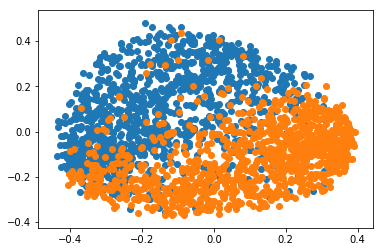

In [5]:
scatter( dfjoin[ dfjoin['Type'] == 'phone' ]['Axis.1'],
         dfjoin[ dfjoin['Type'] == 'phone' ]['Axis.2'] )
scatter( dfjoin[ dfjoin['Type'] == 'shoe'  ]['Axis.1'],
         dfjoin[ dfjoin['Type'] == 'shoe'  ]['Axis.2'] )

In [6]:
distances = {}
shoepoints = {}
phonepoints = {}
for samplename in dfjoin['Sample'] :
    if samplename == 'Unknown' : continue
    sandp = dfjoin[ dfjoin['Sample'] == samplename ]
    if sandp.shape[0] != 2 : continue
    x0 = float(dfjoin[ (dfjoin['Sample'] == samplename) & (dfjoin['Type'] == 'shoe' ) ]['Axis.1'])
    y0 = float(dfjoin[ (dfjoin['Sample'] == samplename) & (dfjoin['Type'] == 'shoe' ) ]['Axis.1'])
    x1 = float(dfjoin[ (dfjoin['Sample'] == samplename) & (dfjoin['Type'] == 'phone') ]['Axis.1'])
    y1 = float(dfjoin[ (dfjoin['Sample'] == samplename) & (dfjoin['Type'] == 'phone') ]['Axis.1'])
    #distances[ samplename ] = sqrt( (x1-x0)**2 + (y1-y0)**2 )
    shoepoints[ samplename ]  = [ x0, y0 ]
    phonepoints[ samplename ] = [ x1, y1 ]

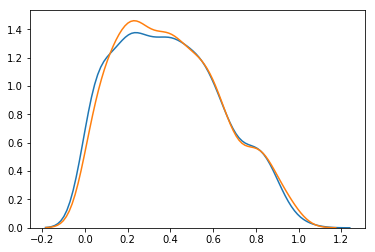

In [7]:
distances = {}
rdistances = {}
for samplename in shoepoints.keys() :
    d0 = sqrt( ( shoepoints[ samplename ][0] - phonepoints[ samplename ][0] )**2 +
               ( shoepoints[ samplename ][1] - phonepoints[ samplename ][1] )**2 )
    
    distances[ samplename ] = d0
    
    rsamplename = random.choice( shoepoints.keys() )

    d1 = sqrt( ( shoepoints[ rsamplename ][0] - phonepoints[ rsamplename ][0] )**2 +
               ( shoepoints[ rsamplename ][1] - phonepoints[ rsamplename ][1] )**2 )

    rdistances[ samplename ] = d1
    
sb.kdeplot(  distances.values() )
sb.kdeplot(  rdistances.values() )

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                           n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

phyla_otus = pd.read_csv( 'filtered_otu_table_phyla.csv', index_col=0 )
phyla_tax = pd.read_csv( 'filtered_taxa_names_phyla.csv', index_col=0 )

X = pd.get_dummies( mdsub[['Type','City','State']] )
#y = mdsub[['Sport','City','State','Type','Run']]
y = phyla_otus.loc[ mdsub.index ]
#y = phyla_tax.reindex( phyla_otus.columns )['Phylum']

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0,
                              n_jobs=5)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
figure( figsize=(16,4) )
title("Feature importances")
bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
xticks(range(X.shape[1]), indices)
xlim([-1, X.shape[1]])

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
#le.fit( mdsub[['Type','City','State']] )
pd.get_dummies(y)

,Type_other,Type_phone,Type_shoe,City_Atlanta,City_Baltimore,City_Castro Valley,City_Chittenango,City_Columbia,City_Denver,City_Dulles,...,State_MA,State_MD,State_NC,State_NY,State_OK,State_OR,State_PA,State_TX,State_Unknown,State_VA
CPR_CP.AB025,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB069,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB081,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB082,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB083,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB084,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB085,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB086,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB087,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB088,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
